# Titanic Competition - Deep Learning

In [1]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 100
LR = 0.01
MOMENTUM = 0.9
DECAY = 0.01

In [2]:
# Setup plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
# Set Matplotlib defaults
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10,
)
plt.rc("animation", html="html5")

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import os
import random


from utils import (
    get_variable_name,
    get_num_missing_values,
    get_categorical_columns,
    MyModel,
    model_init,
)

## Preprocessing

In [3]:
# Read the data
train_data = pd.read_csv("../input/train.csv").set_index("PassengerId")
test_data = pd.read_csv("../input/test.csv").set_index("PassengerId")

X = train_data.copy()
X_test = test_data.copy()

# Drop rows with empty label value
X.dropna(axis=0, subset=["Survived"], inplace=True)
y = X.Survived
X.drop(["Survived"], axis=1, inplace=True)

In [4]:
# What can be definitely dropped?
# Name, Ticket
X.drop(['Name', 'Ticket'], axis=1, inplace=True)
X_test.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [5]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,
1,3,male,22.0,1,0,7.2500,NaN,S
2,1,female,38.0,1,0,71.2833,C85,C
3,3,female,26.0,0,0,7.9250,NaN,S
4,1,female,35.0,1,0,53.1000,C123,S
5,3,male,35.0,0,0,8.0500,NaN,S


In [6]:
get_num_missing_values(X)

Missing values in variable columns:
Age         177
Cabin       687
Embarked      2
dtype: int64


In [7]:
get_categorical_columns(X)

variable columns with categorical data:
[('Sex', 2), ('Embarked', 3), ('Cabin', 147)]


In [8]:
get_num_missing_values(X_test)

Missing values in variable columns:
Age       86
Fare       1
Cabin    327
dtype: int64


In [9]:
get_categorical_columns(X_test)

variable columns with categorical data:
[('Sex', 2), ('Embarked', 3), ('Cabin', 76)]


In [10]:
# With so many Cabin entries missing, the Cabin column can also be removed
X.drop(['Cabin'], axis=1, inplace=True)
X_test.drop(['Cabin'], axis=1, inplace=True)

### Optional dropping Age column

In [11]:
# Select categorical columns
categorical_cols = [cname for cname in X.columns if X[cname].dtype == 'object']
# Select numerical columns
numerical_cols = [
    cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']
]
# Keep selected columns only
my_cols = categorical_cols + numerical_cols

In [12]:
print(categorical_cols)
print(numerical_cols)
print(my_cols)

['Sex', 'Embarked']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Sex', 'Embarked', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [13]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ]
)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

### Transform both the training and the test data

In [14]:
X = preprocessor.fit_transform(X)
X_test = preprocessor.transform(X_test)

## Define the model

In [15]:
input_shape = [X.shape[1]]

## Start testing

In [16]:
model = MyModel()

history_lst = []
val_accuracy_history = []

n = 5


for i in range(n):

    print(f"============================ Run {i+1}/{n} ============================")

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=random.randint(1, 1000)
    )

    model, early_stopping, lrs = model_init(model, LR, MOMENTUM, DECAY)

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping, lrs],
    )

    history_lst.append(history)
    val_accuracy_history.append(
        pd.DataFrame(history.history)["val_binary_accuracy"].iloc[-1]
    )

============================ Run 1/5 ============================
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - binary_accuracy: 0.6211 - loss: 0.7479 - val_binary_accuracy: 0.6704 - val_loss: 0.5960 - learning_rate: 0.0100
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7740 - loss: 0.5819 - val_binary_accuracy: 0.6592 - val_loss: 0.5941 - learning_rate: 0.0100
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8063 - loss: 0.4906 - val_binary_accuracy: 0.6034 - val_loss: 0.6329 - learning_rate: 0.0100
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8193 - loss: 0.4180 - val_binary_accuracy: 0.6145 - val_loss: 0.6358 - learning_rate: 0.0100
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7919 - loss: 0.4494 - val_binary_accuracy: 0.6145 - val_loss: 0.6388 - learning_rate: 0.0100
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8219 - loss: 0.4371 - val_binary_acc

In [17]:
print(
    ('Average accuracy: {:0.4f}' + '\nBest run {}: {:0.4f}').format(
        sum(val_accuracy_history) / len(val_accuracy_history) + 1,
        val_accuracy_history.index(max(val_accuracy_history)),
        max(val_accuracy_history),
    )
)

Average accuracy: 1.8112
Best run 1: 0.8436


<Axes: title={'center': 'Accuracy'}>

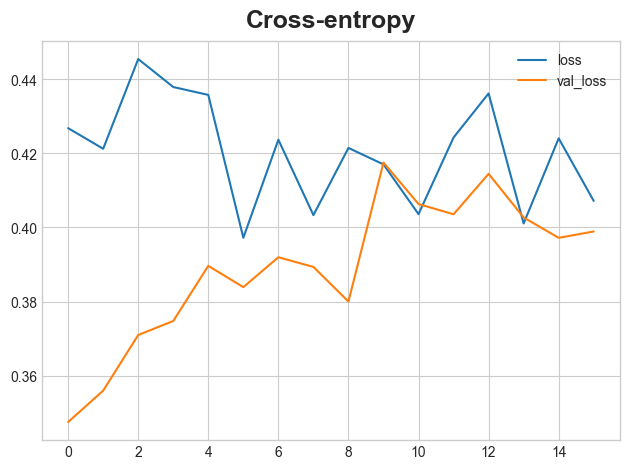

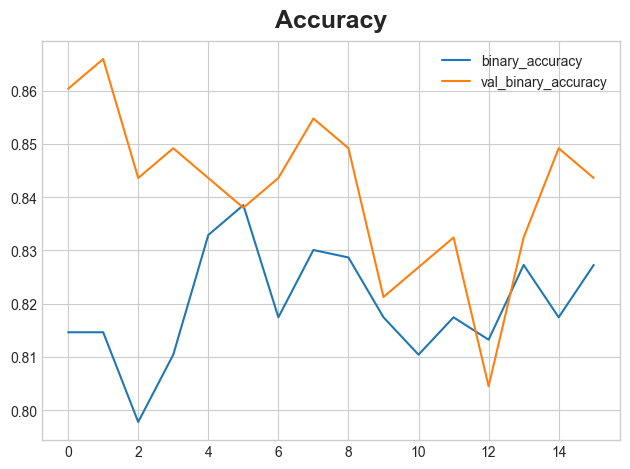

In [18]:
history_df = pd.DataFrame(
    history_lst[val_accuracy_history.index(max(val_accuracy_history))].history
)
history_df.loc[:, ["loss", "val_loss"]].plot(title="Cross-entropy")
history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot(title="Accuracy")

In [19]:
print(
    ("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(
        history_df["val_loss"].min(), history_df["val_binary_accuracy"].max()
    )
)

Best Validation Loss: 0.3475
Best Validation Accuracy: 0.8659


## Submit prediction

In [20]:
# Preprocessing of training data, fit model
model.fit(X, y, batch_size=64, epochs=45)

# Preprocessing of validation data, get predictions
y_pred = (model.predict(X_test) > 0.5).astype(np.intc)

predictions = np.concatenate(y_pred)

# Saving the predictions
output = pd.DataFrame({"PassengerId": test_data.index, "Survived": predictions})

if not os.path.isdir("output/"):
    os.mkdir("output/")

output.to_csv("output/submission.csv", index=False)

print("Your submission was successfully saved!")

Epoch 1/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7988 - loss: 0.4437 
Epoch 2/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8227 - loss: 0.4076 
Epoch 3/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8415 - loss: 0.3919 
Epoch 4/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8370 - loss: 0.3747 
Epoch 5/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8171 - loss: 0.3926 
Epoch 6/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8500 - loss: 0.3539 
Epoch 7/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8274 - loss: 0.4120 
Epoch 8/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8157 - loss: 0.4143 
Epoch 9/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8354 - loss: 0.4095 
Epoch 10/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8297 - loss: 0.3855 
Epoch 11/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8352 - 